In [1]:
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math as math 
import MathsUtilities as MUte
import CAMP as camp
%matplotlib inline
pd.set_option('display.max_rows',1000)

In [2]:
CultParams = pd.read_excel('..\CampVrnParams.xlsx',engine='openpyxl',index_col=0)  
# # Brown etal tests
# ## Bring in final leaf number and Vrn gene expression data
BaseHSTT = [0,2.5,7,14,18]
BaseTT = [110,335,884,2500,3430]
PhenoStages = pd.read_csv('..\dataAnalysis\ProcessedData\PhenoStages.csv')
FLNData = PhenoStages.loc[:,['PhotoP','Vern','Cult','FLN']]
FLNData.set_index(['Cult','Vern','PhotoP'],inplace=True)
Cultivars = list(set(FLNData.index.get_level_values(0)))
PhenoStages.loc[:,'FLTT'] = [np.interp(PhenoStages.loc[x,'FLN'],BaseHSTT,BaseTT)for x in PhenoStages.index]
PhenoStages.loc[:,'TSTT'] = [np.interp(PhenoStages.loc[x,'HSTS'],BaseHSTT,BaseTT)for x in PhenoStages.index]
PhenoStages.loc[:,'FITT'] = [np.interp(PhenoStages.loc[x,'HSFI'],BaseHSTT,BaseTT)for x in PhenoStages.index]
PhenoStages.set_index(['PhotoP','Vern','Cult'],inplace=True)
VrnExpression = pd.read_pickle('..\\dataAnalysis\\RawData\\NZ_CE\\VrnExpression.pkl')
VrnExpression.columns.values[0]='Vrn1'
VrnExpression.columns.values[1]='Vrn2'
VrnExpression.columns.values[2]='Vrn3'
Pps = VrnExpression.Pp.drop_duplicates()
Verns = VrnExpression.Vern.drop_duplicates()
# ## Make a dataframe of model outputs for each treatment
Cultivars

['BattenWinter', 'CRWT153', 'Otane', 'Saracen', 'BattenSpring', 'Amarok']

In [3]:
def RunSingleScenario(D1,T1,P1,T2,P2,CultName,CultParams):
    Days = 200
    Day = range(Days)
    Tt1 = [T1] * D1; Pp1 = [P1] * D1
    Tt2 = [T2] * (Days - D1); Pp2 = [P2] * (Days - D1)
    Tt = Tt1 + Tt2; Pp = Pp1 + Pp2
    outputs = camp.CAMPmodel('',Day,Tt,Pp,CultParams,camp.CampConstants,90)
    outputs.loc[:,'Cultivar'] = CultName
    Vname = lambda V1: 'Full' if (V1==1) else 'Nil'
    outputs.loc[:,'Vernalisation'] = Vname(T1)
    outputs.loc[:,'Photoperiod'] = P2
    outputs.set_index(['Cultivar','Vernalisation','Photoperiod'],inplace=True)
    return outputs

BrownPred = pd.DataFrame(columns = ['Cultivar','Vernalisation','PhotoPeriod'])
BrownPred.set_index(['Cultivar','Vernalisation','PhotoPeriod'],inplace=True)

def CreateCultivarset(CultName,CultPars):
    FVLP = RunSingleScenario(90,1,0,23.6,16,CultName,CultPars)
    FVSP = RunSingleScenario(90,1,0,23.6,8,CultName,CultPars)
    NVLP = RunSingleScenario(90,23.6,16,23.6,16,CultName,CultPars)
    NVSP = RunSingleScenario(90,23.6,8,23.6,8,CultName,CultPars)
    DataTable = pd.concat([FVLP,FVSP])
    DataTable = pd.concat([DataTable,NVLP])
    DataTable = pd.concat([DataTable,NVSP])
    return DataTable

for C in Cultivars:
    BrownPred = pd.concat([BrownPred, CreateCultivarset(C, CultParams.loc[C,:])])
BrownPred.sort_index(inplace=True)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


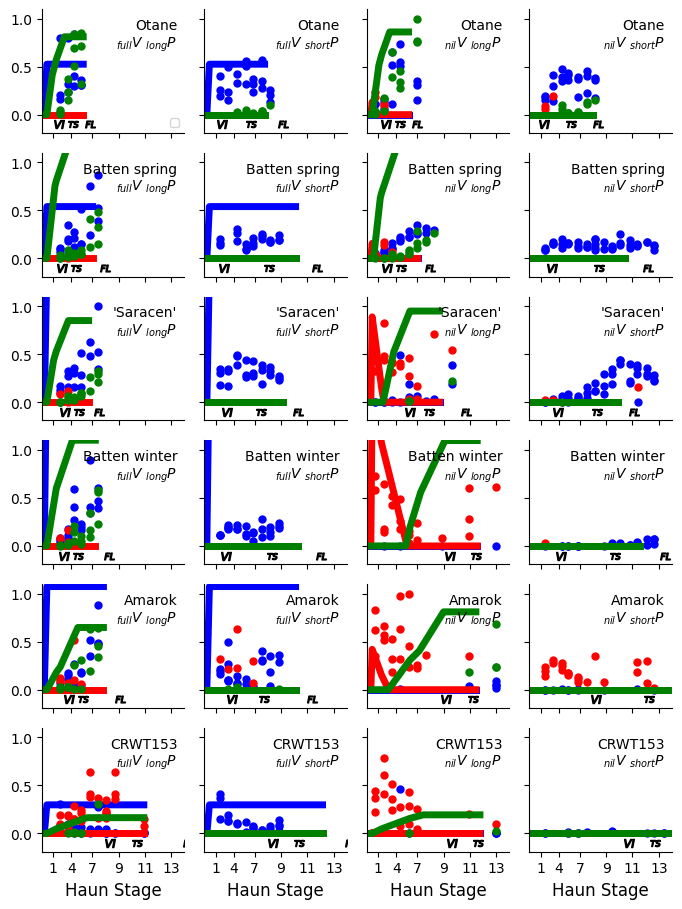

In [4]:
Cultivars = ['Otane', 'BattenSpring', 'Saracen', 'BattenWinter', 'Amarok', 'CRWT153']
CultNames = pd.DataFrame(index = Cultivars,columns=['Name'],data=['Otane',"Batten spring","'Saracen'","Batten winter","Amarok",'CRWT153'])
VernDurats = pd.DataFrame(index=Verns.values,data=[0,100],columns=['Durat'])
GeneNames = pd.DataFrame(index = ['Vrn1','Vrn2','Vrn3'],data=['Vrn1','Vrn2','Vrn3'],columns=['lower'])
PpSymbols = pd.DataFrame(index = [16,8],columns=['Name'],data=['$_{long}P$','$_{short}P$'])
cols = ['b','r','g']
VrnLabs = pd.DataFrame(index=['Full','Nil'],columns=['Lab'],data=['$_{full}V$','$_{nil}V$'])
Fig2 = plt.figure(figsize=(6.92,9.2))
pos = 1
for Cult in ['Otane', 'BattenSpring', 'Saracen', 'BattenWinter', 'Amarok', 'CRWT153']:
    TrtCnt = 1
    for Vern in ['Full','Nil']:
        for Pp in Pps:
            Dur = 300
            Tt1 = [1] * VernDurats.loc[Vern,'Durat']
            Tt2 = [23.6] * (Dur - VernDurats.loc[Vern,'Durat'])
            Tt = Tt1 + Tt2
            Pp1 = [0] * VernDurats.loc[Vern,'Durat']
            Pp2 = [Pp] * (Dur - VernDurats.loc[Vern,'Durat'])
            pp = Pp1 + Pp2
            GEPmodValues = BrownPred.loc[Cult,Vern,Pp]
            ax = Fig2.add_subplot(6,4,pos,)
            colpos = 0
            for Gene in ['Vrn1','Vrn2','Vrn3']:
                    Filter = (VrnExpression.Cult == Cult)&(VrnExpression.Vern == Vern)&(VrnExpression.Pp == Pp)
                    Data = VrnExpression[Filter]
                    Medians = Data.where(Data.isnull()==False,other=0).groupby('SampleDate').median(numeric_only=True)
                    RelExpress = Data.loc[:,Gene]/VrnExpression.loc[:,Gene].max()
                    RelMedians = Medians.loc[:,Gene]/VrnExpression.loc[:,Gene].max()
                    plt.plot(Data.loc[:,'Tt'],RelExpress,'o',ms=5,color=cols[colpos])
                    #plt.plot(Medians.loc[:,'Tt'],RelMedians,'-',lw=3,color=cols[colpos],label = '_nolegend_')
                    lower = GeneNames.loc[Gene,'lower']
                    plt.plot(GEPmodValues.Tt.cumsum(),GEPmodValues.loc[:,lower],lw=5,color=cols[colpos],label = '_nolegend_')
                    colpos+=1
            plt.plot([PhenoStages.loc[(Pp,Vern,Cult),'FITT']],[-.1], marker=u'$VI$',ms=7,color='k')
            plt.plot([PhenoStages.loc[(Pp,Vern,Cult),'TSTT']],[-.1], marker=u'$TS$',ms=7,color='k')
            plt.plot([PhenoStages.loc[(Pp,Vern,Cult),'FLTT']],[-.1], marker=u'$FL$',ms=7,color='k')
            plt.ylim(-0.19,1.1)
            plt.xlim(0,2500)
            HSTicks = [1,4,7,9,11,13,15,17]
            TickPoss = [np.interp(x,BaseHSTT,BaseTT)for x in HSTicks]
            ax.xaxis.set_major_locator(plt.FixedLocator(TickPoss))
            ax.set_xticklabels(HSTicks)
            CultName = CultNames.loc[Cult,'Name']
            label = CultName + '\n' +VrnLabs.loc[Vern,'Lab'] + ' '  + PpSymbols.loc[Pp,'Name']
            plt.text(0.95,0.7,label,fontsize=10,transform=ax.transAxes,horizontalalignment='right')
            if pos == 1:
                plt.legend(loc=4, fontsize=8)
            ax.spines['right'].set_visible(False)
            ax.spines['top'].set_visible(False)
            plt.tick_params(axis='x', which='both', bottom=True,top=False, labelbottom=True,labelsize=10)
            plt.tick_params(axis='y', which='both', left=True,right=False, labelbottom=True,labelsize=10)
            if pos <= 20:
                ax.tick_params(labelbottom=False)
            else:
                plt.xlabel('Haun Stage',fontsize=12)
            ax.tick_params(labelleft=False)
            if pos in [1,5,9,13,17,21]:
                ax.tick_params(labelleft=True)
#             if pos == 9:
#                 plt.text(-.45,.4,'Relative expression',transform=ax.transAxes,rotation=90,fontsize=12)
            pos += 1
            TrtCnt += 1    
Fig2.patch.set_facecolor('white')
plt.tight_layout()

In [5]:
CultParams.columns

Index(['FLN_CL', 'FLN_WL', 'FLN_CS', 'FLN_WS', 'Expt', 'MinLN', 'PpLN',
       'VrnLN', 'VxPLN', 'TS_WS', 'TS_CL', 'TS_CS', 'TS_WL', 'BasePhyllo',
       'PhylloPpSens', 'EmergDurat', 'VernTreatDurat', 'EndVernTreat', 'MinVI',
       'MinVI->TS', 'VI_CL', 'VI_WL', 'VI_CS', 'VI->TS_CS', 'VI_WS',
       'rVrnBVeg', 'rVrnMVeg', 'rVrnBER', 'rVrnMER', 'rVrn3ER', 'rVrn3Veg',
       'URVrn3HSWL', 'DRVrn2HSWL', 'rVrn2', 'VrnPVI_CL', 'VrnBVeg_CL',
       'Vrn1_CL', 'MethalationThreshold', 'CTHS', 'DVrn1_CL', 'DVrn1Max',
       'rVrn1'],
      dtype='object')

In [6]:
FLNData.loc[:,'PredFLN'] = [BrownPred.loc[x,'FLN'].max() for x in FLNData.index]
FLNData.loc[:,'PredVIHS'] = [BrownPred.loc[x,'VIHS'].max() for x in FLNData.index]
FLNData.loc[:,'PredTSHS'] = [BrownPred.loc[x,'TSHS'].max() for x in FLNData.index]
def getVIHS(c,v,p):
    if (v=='Full') and (p==16):
        return CultParams.loc[c,'VI_CL']
    if (v=='Full') and (p==8):
        return CultParams.loc[c,'VI_CS']
    if (v=='Nil') and (p==16):
        return CultParams.loc[c,'VI_WL']
    if (v=='Nil') and (p==8):
        return CultParams.loc[c,'VI_WS']
FLNData.loc[:,'VIHS'] = [getVIHS(x[0],x[1],x[2]) for x in FLNData.index]  

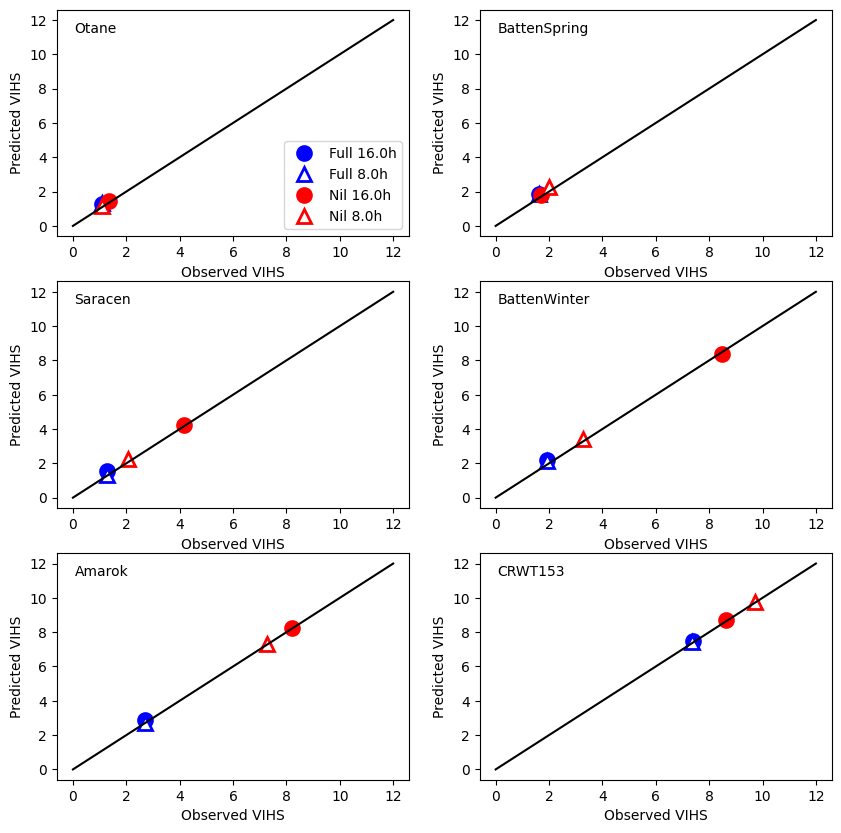

In [7]:
Graph = plt.figure(figsize=(10,10))
pos=1
mecs = ['b','b','r','r']
ms = ['o','^','o','^']
mfcs = ['b','w','r','w']
lns = ['-','-','--','--']
for c in Cultivars:
    ax = Graph.add_subplot(3,2,pos)
    mp = 0
    for v in ['Full','Nil']:
        for p in Pps:
            plt.plot(FLNData.loc[(c,v,p),'VIHS'],FLNData.loc[(c,v,p),'PredVIHS'],
                    ms[mp],mec=mecs[mp],mfc=mfcs[mp],ms=10,mew=2,label = v+ ' '+str(p)+'h')
            mp +=1
    plt.text(0.05,0.9,c,transform=ax.transAxes)
    if pos==1:
        plt.legend(loc=4)
    plt.plot([0,12],[0,12],'-',color='k')
    plt.ylabel('Predicted VIHS')
    plt.xlabel('Observed VIHS')
    pos +=1
Graph.patch.set_facecolor('white')

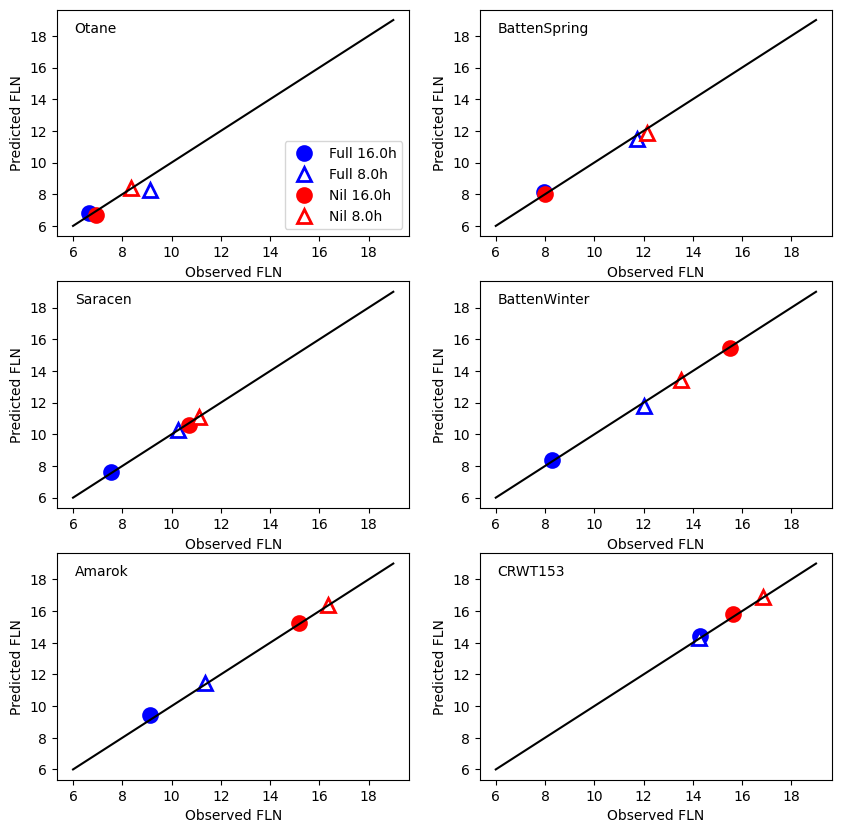

In [8]:
Graph = plt.figure(figsize=(10,10))
pos=1
mecs = ['b','b','r','r']
ms = ['o','^','o','^']
mfcs = ['b','w','r','w']
lns = ['-','-','--','--']
for c in Cultivars:
    ax = Graph.add_subplot(3,2,pos)
    mp = 0
    for v in ['Full','Nil']:
        for p in Pps:
            plt.plot(FLNData.loc[(c,v,p),'FLN'],FLNData.loc[(c,v,p),'PredFLN'],
                    ms[mp],mec=mecs[mp],mfc=mfcs[mp],ms=10,mew=2,label = v+ ' '+str(p)+'h')
            mp +=1
    plt.text(0.05,0.9,c,transform=ax.transAxes)
    if pos==1:
        plt.legend(loc=4)
    plt.plot([6,19],[6,19],'-',color='k')
    plt.ylabel('Predicted FLN')
    plt.xlabel('Observed FLN')
    pos +=1
Graph.patch.set_facecolor('white')

# Brooking and Jamieson tests

## Bring in the Brooking and Jamieson Data for model verification

In [9]:
BnJFLN = pd.read_csv('..\\DataAnalysis\\RawData\\BnJCE\\BnJFLN.csv')
BnJFLN.drop('SimulationName',inplace=True,axis=1)
def changeName(name):
    if name == 'BattenWinter':
        name =  'PNBattenWinter'
    return name
BnJFLN.loc[:,'Genotype'] = [changeName(BnJFLN.loc[x,'Genotype']) for x in BnJFLN.index]
BnJFLN.loc[:,'Temp'] = [BnJFLN.loc[x,'Trt'].split('_')[0] for x in BnJFLN.index]
BnJFLN.loc[:,'Temp'] = [int(BnJFLN.loc[x,'Temp'].replace('oC','')) for x in BnJFLN.index]
BnJFLN.loc[:,'Temp'] = BnJFLN.loc[:,'Temp'].where(BnJFLN.loc[:,'Temp']!=25,23)
#BnJFLN.loc[:,'Temp'] = BnJFLN.loc[:,'Temp'].where(BnJFLN.loc[:,'Temp']!=11,16)
BnJFLN.loc[:,'Pp'] = [BnJFLN.loc[x,'Trt'].split('_')[1] for x in BnJFLN.index]
BnJFLN.loc[:,'Pp'] = [int(BnJFLN.loc[x,'Pp'].replace('h','').replace('Dark','0')) for x in BnJFLN.index]
BnJFLN.drop('Trt',inplace=True,axis=1)
#BnJFLN.loc[:,'Genotype'] = ['Batten Spr' if x == "BattenSpring" else "Batten Win" for x in BnJFLN.loc[:,'Genotype']]
Temps = list(set(BnJFLN.loc[:,'Temp']))
PPs = list(set(BnJFLN.loc[:,'Pp']))
Genotypes = list(set(BnJFLN.loc[:,'Genotype']))
BnJFLN.columns = [u'Genotype', u'FLN', u'Duration', u'Temp', u'Pp']
BnJFLN.loc[:,'Duration'] = BnJFLN.loc[:,'Duration'] * 7
BnJFLN.set_index(['Temp','Pp','Genotype'],inplace=True)
BnJFLN.Duration.where(BnJFLN.Duration!=52.5,56,inplace=True) #fix up a sample data which is off
BnJFLN.Duration.where(BnJFLN.Duration!=67.200000000000003,70,inplace=True)
BnJFLN.set_index('Duration',append=True,drop=False,inplace=True)
BnJFLN.index = BnJFLN.index.swaplevel(2,3)
BnJFLN.FLN.where(BnJFLN.FLN!=0.0,np.nan,inplace=True)
BnJFLN.dropna(inplace=True)
BnJFLN.sort_index(axis=0,inplace=True)
BnJFLN.sort_index(axis=1,inplace=True)

## Create environment data for different treatments

In [10]:
ClimateLabEnvironment = pd.DataFrame(columns=pd.MultiIndex.from_product([[1,5,8,11,23],[0,8,16],range(0,100,7)],names=['Temp','Photoperiod','Duration']),
                                     index = pd.MultiIndex.from_product([['Tt','Pp'],range(220)],names = ['Variable','Day']))
for E in ClimateLabEnvironment.columns:
    if E[0] == 11:
        T = 16
    else:
        T = E[0]
    #T = E[0]
    P = E[1]
    Dur = E[2]
    Tt1 = [T] * Dur
    Tt2 = [23] * (220 - Dur)
    Tt = pd.Series(index = range(220), data = (Tt1 + Tt2))
    ClimateLabEnvironment.loc['Tt',E] = Tt.values 
    Pp1 = [P] * Dur
    Pp2 = [16] * (220 - Dur)
    Pp = pd.Series(index = range(220), data = (Pp1 + Pp2))
    ClimateLabEnvironment.loc['Pp',E] = Pp.values

## Estimate FLN from the GEP model for each of the Brooking and Jamieson treatments

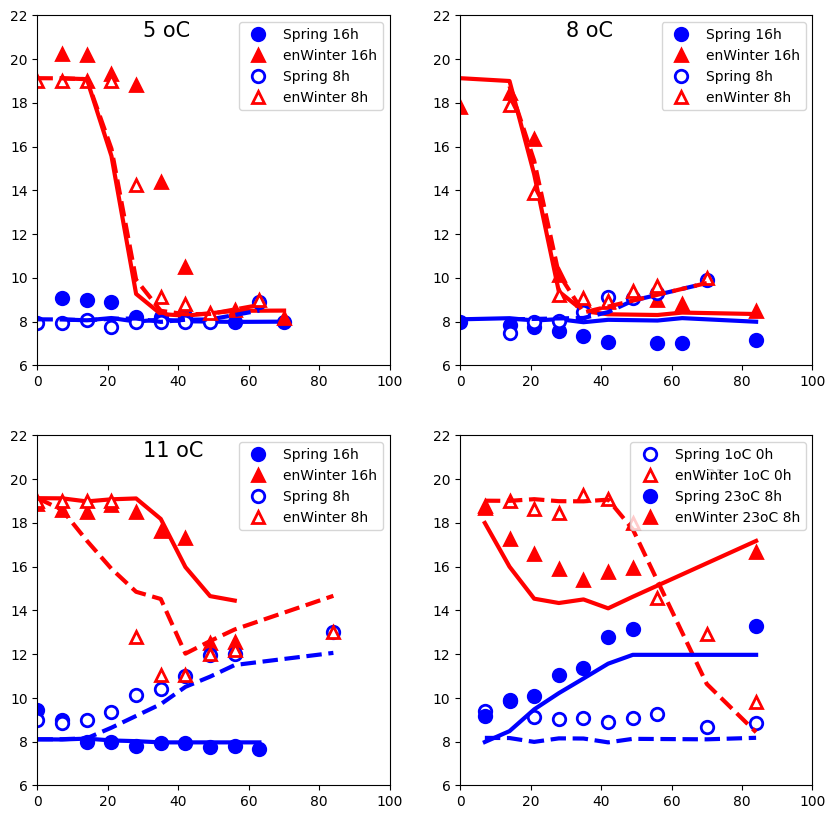

In [11]:
for Trt in BnJFLN.index:
    Day = range(220)
    Tt = ClimateLabEnvironment.loc['Tt',Trt[:-1]]
    Pp = ClimateLabEnvironment.loc['Pp',Trt[:-1]]
    Params = CultParams.loc[Trt[3],:]
    if (Trt[0]==1):
        ttEmerg = 90
    else:
        ttEmerg = 90
    
    GEPFLN = camp.CAMPmodel('FLN',Day,Tt,Pp,Params,camp.CampConstants,ttEmerg)
    BnJFLN.loc[Trt,'PredFLN'] = GEPFLN
    
mecs = ['b','r','b','r']
ms = ['o','^','o','^']
mfcs = ['b','r','w','w']
lns = ['-','-','--','--']

def MakePlot(T):
    pos=0
    for P in [16,8]:
        for G in Genotypes:
            ax = plt.plot(BnJFLN.loc[(T,P,slice(None),G),'Duration'],
                          BnJFLN.loc[(T,P,slice(None),G),'FLN'],
                          ms[pos],mec=mecs[pos],mfc=mfcs[pos],lw=3,ms=9,mew=2,label=G[6:] + ' ' + str(P) + 'h')
            plt.plot(BnJFLN.loc[(T,P,slice(None),G),'Duration'],
                          BnJFLN.loc[(T,P,slice(None),G),'PredFLN'],
                          lns[pos],color=mecs[pos],lw=3,ms=9,mew=2)
            pos+=1
    plt.legend()
    plt.text(30,21,str(T) + ' oC',fontsize=15)
    plt.ylim(6,22)
    plt.xlim(0,100)

Graph = plt.figure(figsize=(10,10))
Graph.add_subplot(2,2,1)
MakePlot(5)
Graph.add_subplot(2,2,2)
MakePlot(8)
Graph.add_subplot(2,2,3)
MakePlot(11)
Graph.add_subplot(2,2,4)
T = 1
P = 0
pos=0
for G in Genotypes:
    ax = plt.plot(BnJFLN.loc[(T,P,slice(None),G),'Duration'],
                  BnJFLN.loc[(T,P,slice(None),G),'FLN'],
                  ms[pos],mec=mecs[pos],mfc='w',lw=3,ms=9,mew=2,label= G[6:] + ' 1oC 0h')
    plt.plot(BnJFLN.loc[(T,P,slice(None),G),'Duration'],
                          BnJFLN.loc[(T,P,slice(None),G),'PredFLN'],
                          '--',color=mecs[pos],lw=3,ms=9,mew=2)
    pos +=1
T = 23
P = 8
for G in Genotypes:
    ax = plt.plot(BnJFLN.loc[(T,P,slice(None),G),'Duration'],
                  BnJFLN.loc[(T,P,slice(None),G),'FLN'],
                  ms[pos],color=mecs[pos],lw=3,ms=9,mew=2,label= G[6:] + ' 23oC 8h')
    plt.plot(BnJFLN.loc[(T,P,slice(None),G),'Duration'],
                          BnJFLN.loc[(T,P,slice(None),G),'PredFLN'],
                          '-',color=mecs[pos],lw=3,ms=9,mew=2)
    pos +=1
    plt.legend()
    plt.text(70,20,str(T))
    plt.ylim(6,22)
    plt.xlim(0,100)
Graph.patch.set_facecolor('white')

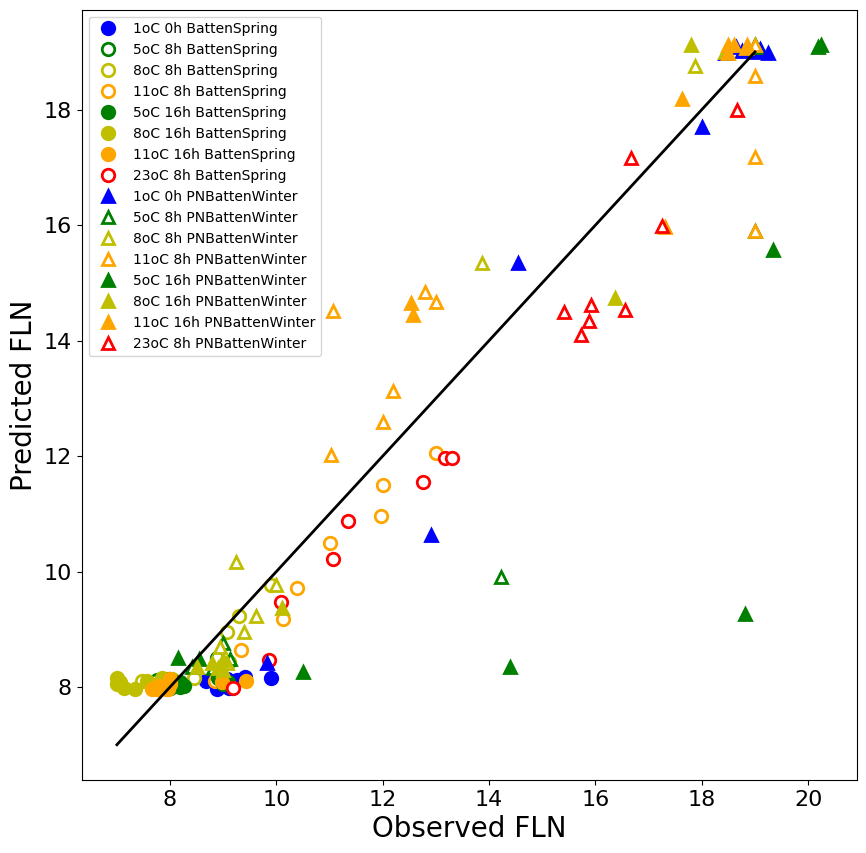

In [12]:
Graph = plt.figure(figsize=(10,10))
Graph.add_subplot(1,1,1)
ms = ['o','^']
mecs = ['b','g','y','orange','g','y','orange','r']
mfcs = ['b','white','white','white','g','y','orange','white']
mp = 0
for G in Genotypes:
    cp = 0
    for e in [(0,1),(8,5),(8,8),(8,11),(16,5),(16,8),(16,11),(8,23)]:
        plt.plot(BnJFLN.loc[(e[1],e[0],slice(None),G),'FLN'],
                BnJFLN.loc[(e[1],e[0],slice(None),G),'PredFLN'],
                 ms[mp],mec=mecs[cp],mfc=mfcs[cp],lw=3,ms=9,mew=2,
                 label=str(e[1])+'oC '+ str(e[0])+'h ' + G)
        cp +=1
    mp += 1
plt.ylabel('Predicted FLN',fontsize=20)
plt.xlabel('Observed FLN',fontsize=20)
plt.plot([7,19],[7,19],'-',color='k',lw=2)
plt.tick_params(labelsize=16)
plt.legend()
Graph.patch.set_facecolor('white')

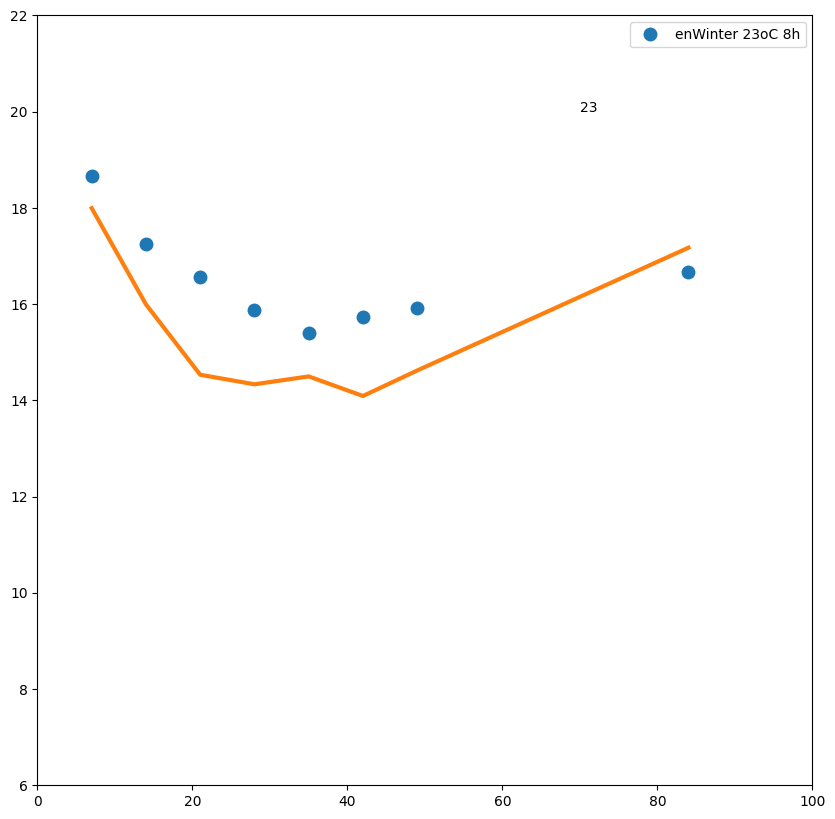

In [13]:
for Trt in BnJFLN.loc[(23,8,slice(None),'PNBattenWinter'),:].index:
    Day = range(220)
    Tt = ClimateLabEnvironment.loc['Tt',Trt[:-1]]
    Pp = ClimateLabEnvironment.loc['Pp',Trt[:-1]]
    Params = CultParams.loc[Trt[3],:]
    GEPFLN = camp.CAMPmodel('FLN',Day,Tt,Pp,Params,camp.CampConstants,90)
    BnJFLN.loc[Trt,'PredFLN'] = GEPFLN
    
    
mecs = ['b','r','b','r']
ms = ['o','^','o','^']
mfcs = ['b','r','w','w']
lns = ['-','-','--','--']

def MakePlot(T):
    pos=0
    for P in [16,8]:
        for G in Genotypes:
            ax = plt.plot(BnJFLN.loc[(T,P,slice(None),G),'Duration'],
                          BnJFLN.loc[(T,P,slice(None),G),'FLN'],
                          ms[pos],mec=mecs[pos],mfc=mfcs[pos],lw=3,ms=9,mew=2,label=G[6:] + ' ' + str(P) + 'h')
            plt.plot(BnJFLN.loc[(T,P,slice(None),G),'Duration'],
                          BnJFLN.loc[(T,P,slice(None),G),'PredFLN'],
                          lns[pos],color=mecs[pos],lw=3,ms=9,mew=2)
            pos+=1
    plt.legend()
    plt.text(30,21,str(T) + ' oC',fontsize=15)
    plt.ylim(6,22)
    plt.xlim(0,100)

Graph = plt.figure(figsize=(10,10))
Graph.add_subplot(1,1,1)
T = 23
P = 8
for G in ['PNBattenWinter']:
    ax = plt.plot(BnJFLN.loc[(T,P,slice(None),G),'Duration'],
                  BnJFLN.loc[(T,P,slice(None),G),'FLN'],
                  'o',ms=9,label= G[6:] + ' 23oC 8h')
    plt.plot(BnJFLN.loc[(T,P,slice(None),G),'Duration'],
                          BnJFLN.loc[(T,P,slice(None),G),'PredFLN'],
                          '-',lw=3,ms=9,mew=2)
    plt.legend()
    plt.text(70,20,str(T))
    plt.ylim(6,22)
    plt.xlim(0,100)
Graph.patch.set_facecolor('white')